### Exponential Kernel Hawkes Process

The kernel function for a univariate Hawkes process is assumed to be:

$$
\varphi(x) = \beta \exp(-\beta x)
$$

For a multivariate hawkes process with exponential kernels, will take the intensity function of the point process to be:

$$
\lambda^{(i)}(t) = \lambda_0^{(i)} + \sum_j \phi_{ij} \int_0^t  \beta_j \exp(-\beta_j s) dN^{(j)}_s
$$

or in more familiar sum notation


$$
\lambda^{(i)}(t) = \lambda_0^{(i)} + \sum_j \phi_{ji} \sum_k  \beta_{i} \exp(-\beta_{i} (t_i - t_k)) 
$$

Take the univariate case with intensity function

$$
\lambda(t) = \lambda + \sum_{k=0}^{N_t} \alpha \exp(- \beta (t - t_k))
$$

TERM 2 of the log-likelihood becomes:
$$
\sum_i \log ( \lambda + \alpha \sum_{k=0}^{i} \exp(-\beta (t_i - t_k)) )
$$ 

which, through the memoryless property of exponential distributions.. we can write the recursion:

$$
\begin{align}
B(i) &= \sum_{k=0}^{i-1} \exp(-\beta (t_i - t_k)) \\
     &= \sum_{k=0}^{i-1} \exp(-\beta (t_i - t_{i-1})) \exp(-\beta(t_{i-1} - t_k)) \\
     &= \exp(-\beta (t_i - t_{i-1})) \sum_{k=0}^{i-1}  \exp(-\beta(t_{i-1} - t_k)) \\
     &= \exp(-\beta (t_i - t_{i-1})) \left[ \exp(-\beta(t_{i-1} - t_{i-1})) + \sum_{k=0}^{i-2}  \exp(-\beta(t_{i-1} - t_k)) \right] \\
     &= \exp(-\beta (t_i - t_{i-1})) \left[ 1 + B(i-1) \right]
\end{align}
$$

where by definition $B(1) = 0$.

Finally TERM 2 of log likelihood can be given by:

$$
\sum_i \log ( \lambda + \alpha B(i) )
$$ 

Below we first implement a sampler for the univariate Hawkes process. Then, we solve for maximum likelihood parameters implementing the log-likelihood function mentioned above and using a numerical solver.

In [7]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [8]:
def hawkes_draw(T, mu, alpha, beta):
    """
    Draw from a univariate Hawkes process with
    exponential  kernel $-\alpha * \exp(-\beta * (t - t'))$
    """
    assert alpha < beta, "Not stationary!"
    assert np.min([mu, alpha, beta]) > 0, "Parameters cannot be zero!"

    arr = []
    s, n = 0, 0

    while s < T:
        lda_bar = mu + np.sum(alpha * np.exp(- beta * (s - np.array(arr))))

        u = np.random.rand()
        w = - np.log(u) / lda_bar
        s += w

        D = np.random.rand()
        if D * lda_bar <= mu + np.sum(alpha * np.exp(- beta * (s - np.array(arr)))):
            n += 1
            arr.append(s)

    if arr[-1] > T:
        arr = arr[:-1]
        
    return arr

In [32]:
def _hawkes_exp_ll(ser, lda0, alpha, beta):
    
    d = np.diff(ser)
    exp_diff = np.exp(-beta * d)
    T = ser[-1]
    B = np.zeros(len(ser))

    for i, _d in enumerate(exp_diff):
        B[i+1] = (1 + B[i]) * _d
    #     term2 += np.log(lda + alpha * B[])

    return np.sum(np.log(lda0 + alpha * B)) - np.sum(1 - np.exp(-beta * (T - ser))) * alpha / beta - lda0 * T

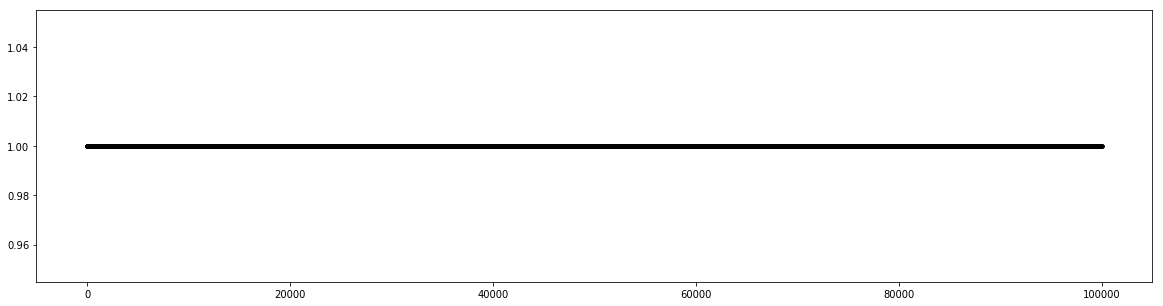

In [37]:
arr = hawkes_draw(100000, .1, .3, .5)

plt.figure(figsize=(20,5))
plt.plot(np.array(arr), np.ones(len(arr)), 'k.')

In [34]:
##_hawkes_exp_ll(arr, 1.6e7, 0, 1)


-15889327784.680714

In [38]:
from scipy.optimize import minimize
minres = minimize(lambda x: -_hawkes_exp_ll(arr, x[0], x[1], x[2]),
                     x0=np.array([5, .2, .3]),
                     bounds=[(0, None), (0, 1), (0, 1)],
                     method="L-BFGS-B")

/home/caner/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [39]:
minres

      fun: 93313.868514818081
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 73127.5533326 ,   8985.39292393,   -457.05965022])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 2
   status: 0
  success: True
        x: array([ 0.90518845,  0.03620754,  0.87327362])